In [1]:
# Load the necessary Python packages for the analysis.
%matplotlib inline

import os
import datacube
import pickle
import math
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from datacube.utils.geometry import Geometry
from deafrica_tools.plotting import plot_lulc
from deafrica_tools.spatial import xr_rasterize

In [2]:
# Connect to the datacube to access DE Africa data.
# The `app` parameter is a unique name for the analysis which is based on the notebook file name.
dc = datacube.Datacube(app="Landcover_Reclassification")

In [3]:
# Set important parameters for the analysis.

# Set the bands/measurements of the satellite data to load.
measurements = "classification"

# Set the time period of interest for your analysis.
time_range = ("2014", "2019")

# Set the x and y cell resolution of the satellite data.
# If loading a large area, then increase the resolution so the data will fit into memory.
resolution = (-300, 300)

# Set the Coordinate Reference System (CRS) the satellite data is to be reprojected to.
# output_crs = "EPSG:32632"
output_crs = "EPSG:6933"

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Load the African Countries GeoJSON.
# This file contains polygons for the boundaries of African countries.
african_countries = gpd.read_file("../Supplementary_data/MGCI/african_countries.geojson")

# List the countries in the African Countries GeoJSON.
np.unique(african_countries["COUNTRY"])

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [5]:
# Select an African country to carry out the analysis over.
country = "Tunisia"

# The country selected needs to be transformed into a geometry object to be used in the dc.load() function.
idx = african_countries[african_countries["COUNTRY"] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

In [6]:
# Create a reusable datacube query object.
query = {"geopolygon": geom,
         "time": time_range,
         "measurements": measurements,
         "resolution": resolution,
         "output_crs": output_crs}

In [7]:
# Load the ESA Climate Change Initiative Land Cover dataset at 300m resolution.
ds_cci = dc.load(product="cci_landcover", **query)

# Convert the no data values to np.nan.
ds_cci = ds_cci.where(ds_cci != 0)

In [8]:
# Mask the dataset with the country polygon.
african_countries = african_countries.to_crs(output_crs)
mask = xr_rasterize(african_countries[african_countries["COUNTRY"] == country], ds_cci)
ds_cci = ds_cci.where(mask)

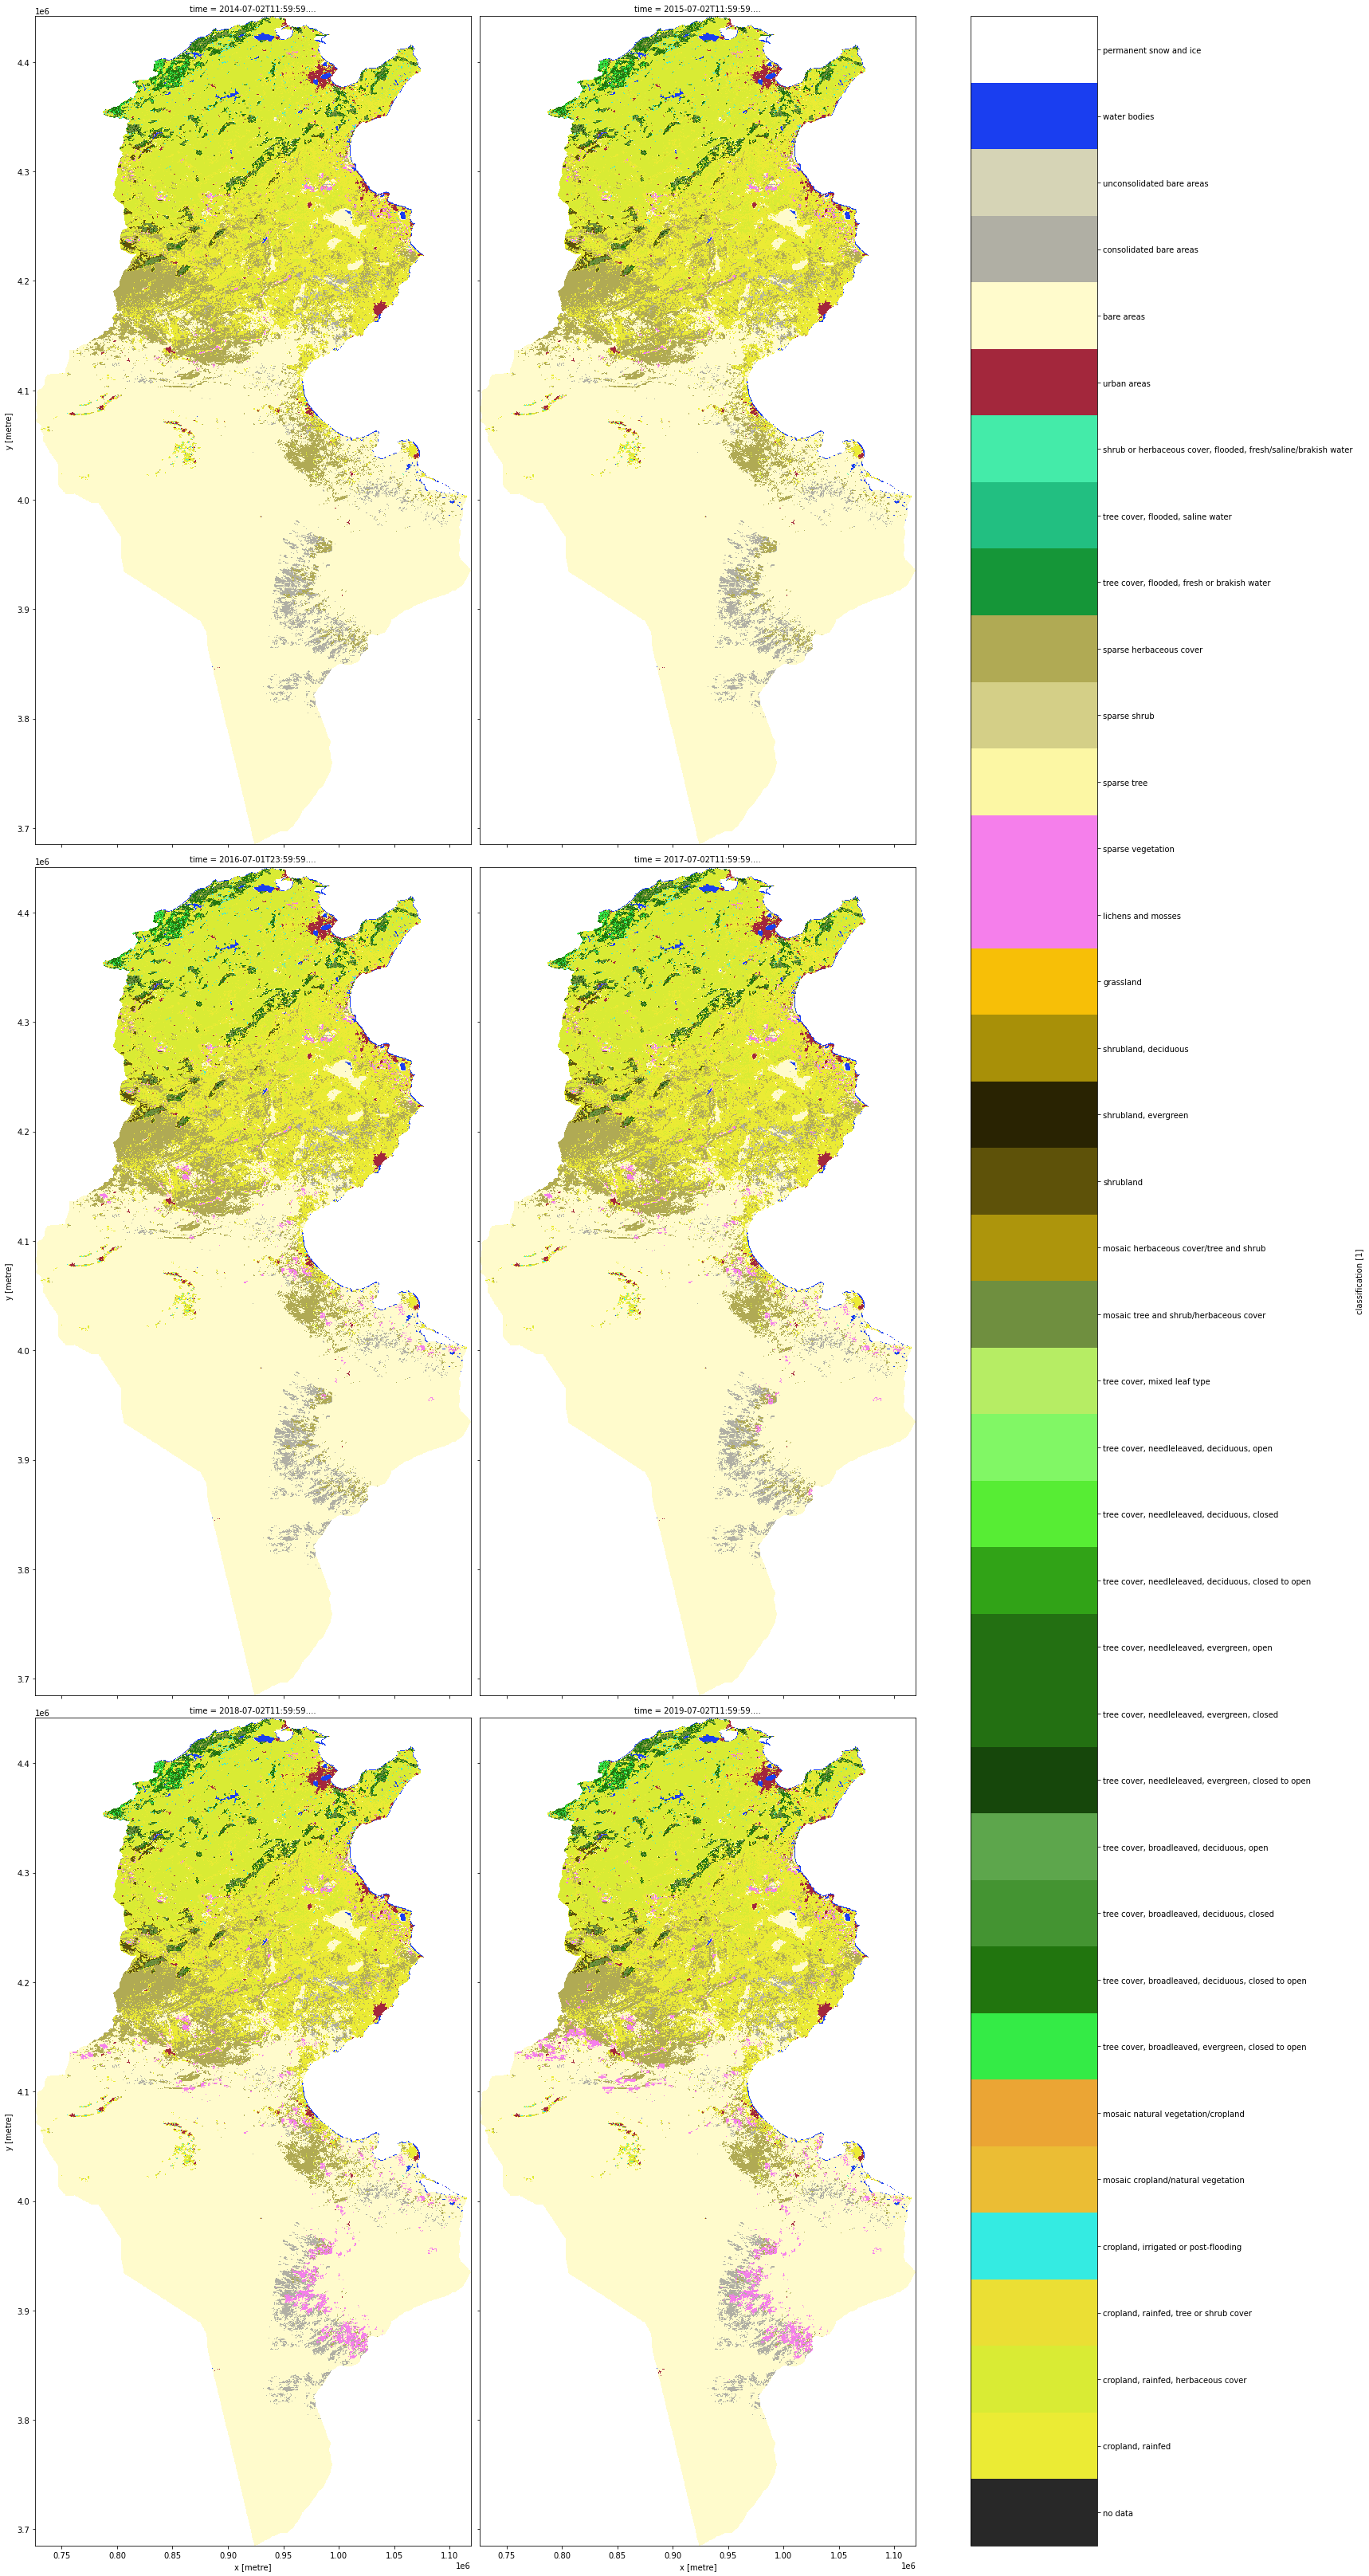

In [9]:
# Plot the CCI Landcover dataset.
plot_lulc(ds_cci["classification"], product="CCI", col="time", col_wrap=2, figsize=(20, 45));

In [10]:
# Reclassify the CCI land Cover dataset into seven land use unit categories.

# Define the labels and codes of the aggregated land cover classes.
CNULCD_labels = ["Treed areas", "Prairies", "Cultivated land", "Wetlands", "Artificial surfaces", "Other land", "Water bodies"]
CNULCD_codes = [1, 2, 3, 4, 5, 6, 7]
# Define the colors to be used to represent the aggregated land use unit categories.
CNULCD_colors = ["#054907", "#ffa500", "#ffff00", "#95d0fc", "#dc143c", "#d6d4b6", "#069af3"]


ds_clas = ds_cci["classification"]

# Reclassification
treed_areas = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100]
priaries = [110, 120, 121, 122, 130, 140, 150, 151, 152, 153]
cultivated_land = [10, 11, 12, 20, 30, 40]
wetlands = [160, 170, 180]
artificial_surfaces = [190]
other_land = [200, 201, 202, 220]
waterbodies = [210]

reclassification_condition = [ds_clas.isin(treed_areas),
                              ds_clas.isin(priaries),
                              ds_clas.isin(cultivated_land),
                              ds_clas.isin(wetlands),
                              ds_clas.isin(artificial_surfaces),
                              ds_clas.isin(other_land),
                              ds_clas.isin(waterbodies)]

ds_cci["reclassification"] = xr.DataArray(data=np.select(reclassification_condition, CNULCD_codes),
                                          coords={"time": ds_cci.time, "y": ds_cci.y, "x": ds_cci.x},
                                          dims=["time", "y", "x"]).astype("int8").where(mask)

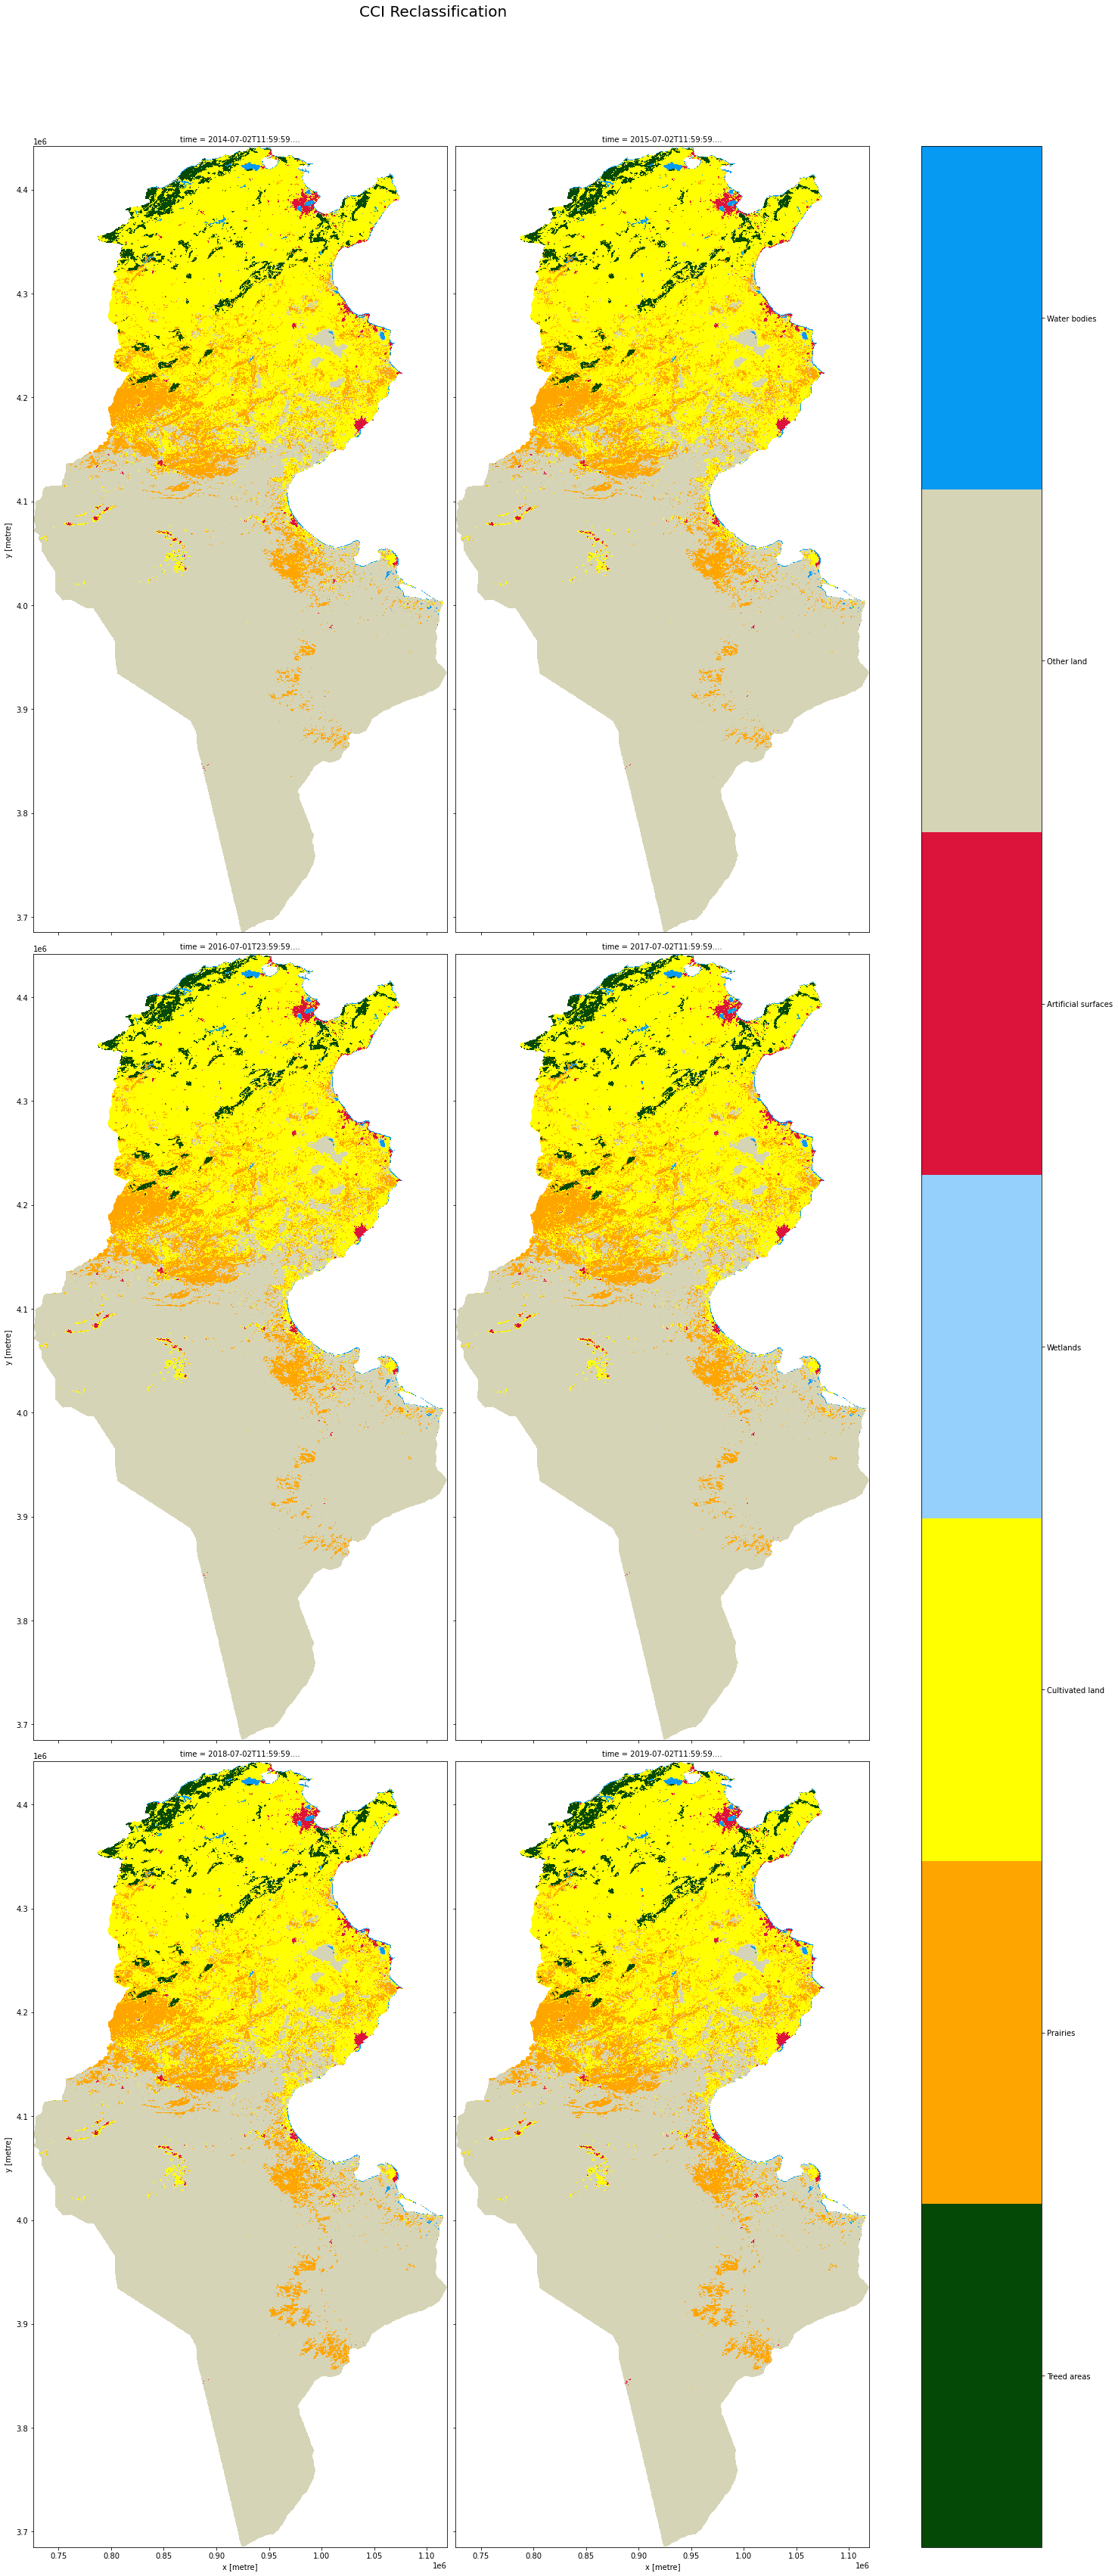

In [11]:
# Define the Reclassification specific color map.
cmap = mcolors.ListedColormap(colors=CNULCD_colors, N=len(CNULCD_codes))
bounds = np.arange(min(CNULCD_codes) - 0.5, max(CNULCD_codes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the IPCC Land Cover.
clas = ds_cci["reclassification"].plot(col="time", col_wrap=2, add_colorbar=False, figsize=(20, 45), cmap=cmap, norm=norm)

clas.fig.suptitle("CCI Reclassification", x=0.4, y=1.05, size=20)
clasp = plt.colorbar(clas._mappables[-1], ax=clas.axes, ticks=CNULCD_codes)
clasp.set_ticklabels(CNULCD_labels)
plt.savefig(f"{output_dir}/{country.replace(' ', '')}_lulc_reclassification.png")
plt.show()

In [12]:
# Get the resolution i.e. actual ground distance represented by the length of a single pixel in meters.
pixel_length = query["resolution"][1]
# Conversion from metres sqaured to hectares.
m2_per_ha = 10000
# Get the actual ground area represented by each pixel.
area_per_pixel = (pixel_length ** 2) / m2_per_ha

In [13]:
# For each year, get the area of each land cover class
# Empty dictionary to store the loop results.
results = {}

# Group the reclassification xarray.DataArray by year.
for year, ds_year in ds_cci["reclassification"].groupby("time.year"):
    # Convert the xarray.DataArray to a numpy array.
    ds_np = ds_year.values
    # Use the numpy np.unique function to return the pixel count for each land cover class.
    ds_counts = np.unique(ds_np, return_counts=True)
    # Calculate the area of each land cover class.
    # Remove the last value as it represents the area of pixels with the value np.nan.
    ds_area = np.array(ds_counts[1] * area_per_pixel)[:-1]

    results[year] = dict(zip(CNULCD_labels, ds_area))

In [14]:
# Convert the results dictionary into a pandas DataFrame.
results_df = pd.DataFrame.from_dict(results)
results_df.to_csv(f"{output_dir}/{country.replace(' ', '')}_lulc_reclassification_result.csv")
results_df

,2014,2015,2016,2017,2018,2019
Treed areas,381303.0,381303.0,382455.0,382581.0,384507.0,385506.0
Prairies,1407942.0,1407924.0,1442088.0,1448181.0,1526265.0,1550007.0
Cultivated land,4621401.0,4620465.0,4618017.0,4611033.0,4607937.0,4606749.0
Wetlands,558.0,558.0,558.0,549.0,549.0,540.0
Artificial surfaces,108351.0,109764.0,109764.0,116694.0,120960.0,124191.0
Other land,8844786.0,8844381.0,8811513.0,8805339.0,8724159.0,8697384.0
Water bodies,85482.0,85428.0,85428.0,85446.0,85446.0,85446.0


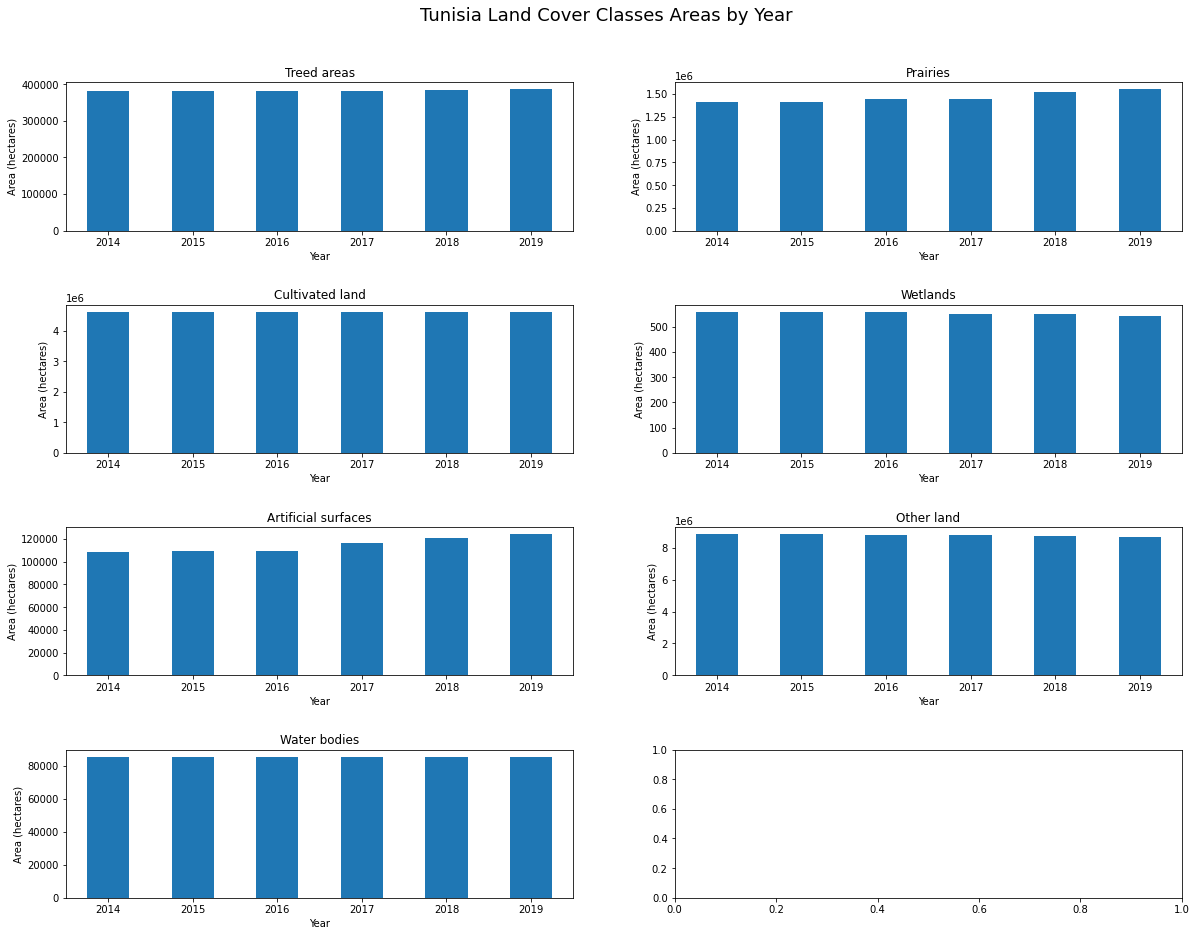

In [15]:
# Plot the area represented by each land cover class over time.

# Transpose the results.df pandas dataframe.
results_df_1 = results_df.T

# Define subplot grid.
ncols = 2
nrows = math.ceil(len(CNULCD_labels) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle(f"{country} Land Cover Classes Areas by Year", fontsize=18, y=0.95)

for i, lulc_class in enumerate(CNULCD_labels):
    results_df_1[lulc_class].plot.bar(
        title=f"{lulc_class}",
        xlabel="Year",
        ylabel="Area (hectares)",
        rot=0,
        ax=axs.reshape(-1)[i],
    )
    
plt.savefig(f"{output_dir}/{country.replace(' ', '')}_lulc_reclassification_chart.png")

## Area change matrix

In [16]:
# Change the default decimal precision used for printing dataframes.
pd.set_option("display.precision", 2)

# Custom styling function to change the background of a cell.  
def lulc_set_background_color(df):

    # Define the background colors to be used for the input dataFrame cells.
    # based on the type of land cover change.
    dont_color = "background-color : white"
    stable = "background-color : orange"
    bad = "background-color : red"
    excellent = "background-color: green"

    # Create a copy of the input dataframe. 
    df1 = df.copy(deep=True)

    # Get the name of the first column.
    first_column = df1.columns[0]
    
    # Define the stable land cover change.
    df1.loc[df1.index[df1[first_column] == "Treed areas"], ["Treed areas", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Prairies"], [ "Prairies", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Cultivated land"], [ "Cultivated land", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Wetlands"], [ "Wetlands", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Artificial surfaces"], ["Artificial surfaces", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Other land"], ["Other land", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Water bodies"], ['Treed areas', 'Prairies', 'Cultivated land', 'Wetlands', 'Artificial surfaces', 'Other land', 'Water bodies']] = stable

    # Define the negative/bad land cover changes.
    df1.loc[df1.index[df1[first_column] == "Treed areas"], ["Prairies", "Cultivated land", "Wetlands","Artificial surfaces", "Other land"]] = bad
    df1.loc[df1.index[df1[first_column] == "Prairies"], [ "Wetlands", "Artificial surfaces", "Other land"]] = bad
    df1.loc[df1.index[df1[first_column] == "Cultivated land"], [ "Prairies", "Wetlands", "Artificial surfaces", "Other land"]] = bad
    df1.loc[df1.index[df1[first_column] == "Wetlands"], [ "Treed areas", "Prairies", "Cultivated land", "Artificial surfaces", "Other land"]] = bad
    df1.loc[df1.index[df1[first_column] == "Other land"], "Artificial surfaces"] = bad

    # Define the positive/excellent land cover changes.
    df1.loc[df1.index[df1[first_column] == "Prairies"], ["Treed areas", "Cultivated land"]] = excellent
    df1.loc[df1.index[df1[first_column] == "Cultivated land"], "Treed areas"] = excellent
    df1.loc[df1.index[df1[first_column] == "Artificial surfaces"], [ "Treed areas", "Prairies", "Cultivated land", "Wetlands", "Other land"]] = excellent
    df1.loc[df1.index[df1[first_column] == "Other land"], ["Treed areas", "Prairies", "Cultivated land", "Wetlands"]] = excellent
    
    # Set the background color for the cells in the first column. 
    df1.loc[df1.index, first_column] = dont_color

    return df1

# Define function to add a title to the pandas dataframe.
def make_pretty(styler, title):
    # Add a title to the dataframe.
    styler.set_caption(title) 
    # Increase the font size and bold the dataframe title.
    title_style = dict(selector="caption", props=[("font-weight", "bold"), 
                                                  ("font-size", "14px")])
    styler.set_table_styles([title_style])
    # Hide the dataframe index when displaying the dataframe.
    styler.hide_index() 
    return styler

In [17]:
# Generate the reference LULC zone change matrix.
row_labels = CNULCD_labels
column_labels = CNULCD_labels

# Create a dataframe where all changes are classified as stable.
ref_lulc_change_matrix = pd.DataFrame(data="Stable", index=row_labels , columns=column_labels)
# Set the index column name
ref_lulc_change_matrix.index.name = "Year of follow up <br> Initial Year"

# Define the negative/bad land cover changes.
ref_lulc_change_matrix.loc["Treed areas", ["Prairies", "Cultivated land", "Wetlands","Artificial surfaces", "Other land"]] = "Bad"
ref_lulc_change_matrix.loc["Prairies", [ "Wetlands", "Artificial surfaces", "Other land"]] = "Bad"
ref_lulc_change_matrix.loc["Cultivated land", [ "Prairies", "Wetlands", "Artificial surfaces", "Other land"]] = "Bad"
ref_lulc_change_matrix.loc["Wetlands", [ "Treed areas", "Prairies", "Cultivated land", "Artificial surfaces", "Other land"]] = "Bad"
ref_lulc_change_matrix.loc["Other land", "Artificial surfaces"] = "Bad"

# Define the positive/excellent land cover changes.
ref_lulc_change_matrix.loc["Prairies", ["Treed areas", "Cultivated land"]] = "Excellent"
ref_lulc_change_matrix.loc["Cultivated land", "Treed areas"] = "Excellent"
ref_lulc_change_matrix.loc["Artificial surfaces", [ "Treed areas", "Prairies", "Cultivated land", "Wetlands", "Other land"]] = "Excellent"
ref_lulc_change_matrix.loc["Other land", ["Treed areas", "Prairies", "Cultivated land", "Wetlands"]] = "Excellent"

# Reset the index.
ref_lulc_change_matrix.reset_index(inplace=True)
# Style the dataframe.
ref_lulc_change_matrix = ref_lulc_change_matrix.style.apply(lulc_set_background_color, axis=None).pipe(make_pretty, title="LULC Zone Change Matrix")

In [18]:
# Generate the change matrix for the selected initial and follow up year
initial_year = "2015"
followup_year = "2019"

# Map the class labels to the class values.
class_dict = dict(zip(CNULCD_codes, CNULCD_labels))

# Select the initial year from which to determine change from.
t0 = ds_cci["reclassification"].sel(time=initial_year).squeeze().values

# Select the folow up year to use to determine if there is change in a pixel.
tn = ds_cci["reclassification"].sel(time=followup_year).squeeze().values

change_results_per_class = {}
for class_value in CNULCD_codes:
    area_changed = {}
    for change_class_value in CNULCD_codes:
        # Get the pixels where change occored.
        change = np.where((t0 == class_value) & (tn == change_class_value), 1, np.nan)
        # Use the numpy np.unique function to return the pixel count for the changed pixels.
        counts = np.unique(change, return_counts=True)
        # Calculate the area of each land cover class.
        # Remove the last value as it represents the area of pixels with the value np.nan.
        area = np.array(counts[1] * area_per_pixel)[:-1]
        # Check for empty arrays.
        if len(area)==1:
            area = area.item()
        else:
            area = 0
        area_changed[class_dict[change_class_value]] = area

    change_results_per_class[class_dict[class_value]] = area_changed
    

# Create a pandas dataframe with from the results.    
lulc_change_matrix = pd.DataFrame.from_dict(change_results_per_class)
# Set the index column name.
lulc_change_matrix.index.name = f"{followup_year} <br> {initial_year}"
# Reset the index. 
lulc_change_matrix.reset_index(inplace=True)
# Style the dataframe.
lulc_change_matrix = lulc_change_matrix.style.apply(lulc_set_background_color, axis=None).pipe(make_pretty, title=f"{initial_year} to {followup_year} {country} LULC Zone Change Matrix (hectares)")

In [19]:
display(ref_lulc_change_matrix)

Year of follow up Initial Year,Treed areas,Prairies,Cultivated land,Wetlands,Artificial surfaces,Other land,Water bodies
Treed areas,Stable,Bad,Bad,Bad,Bad,Bad,Stable
Prairies,Excellent,Stable,Excellent,Bad,Bad,Bad,Stable
Cultivated land,Excellent,Bad,Stable,Bad,Bad,Bad,Stable
Wetlands,Bad,Bad,Bad,Stable,Bad,Bad,Stable
Artificial surfaces,Excellent,Excellent,Excellent,Excellent,Stable,Excellent,Stable
Other land,Excellent,Excellent,Excellent,Excellent,Bad,Stable,Stable
Water bodies,Stable,Stable,Stable,Stable,Stable,Stable,Stable


In [20]:
display(lulc_change_matrix)

2019 2015,Treed areas,Prairies,Cultivated land,Wetlands,Artificial surfaces,Other land,Water bodies
Treed areas,380718.00,900.00,3573.00,0.00,0.00,315.00,0.00
Prairies,135.00,1403109.00,4086.00,0.00,0.00,142677.00,0.00
Cultivated land,342.00,3348.00,4602213.00,0.00,0.00,846.00,0.00
Wetlands,0.00,0.00,0.00,540.00,0.00,0.00,0.00
Artificial surfaces,90.00,360.00,10206.00,9.00,109764.00,3762.00,0.00
Other land,9.00,207.00,387.00,0.00,0.00,8696781.00,0.00
Water bodies,9.00,0.00,0.00,9.00,0.00,0.00,85428.00


In [21]:
# Export the above LULC zone change matrices as csv files.
ref_lulc_change_matrix.data.to_csv(f"{output_dir}/{country.replace(' ', '')}_reference_lulc_change_matrix.csv", index=False)
lulc_change_matrix.data.to_csv(f"{output_dir}/{country.replace(' ', '')}_{initial_year}_to_{followup_year}_lulc_change_matrix.csv", index=False)

## Generate a xarray.DataArray for the change

In [22]:
# Generate an xarray.DataArray where the negative, positive and stable changes occurred. 

# Define the types of land cover change.
# stable
stable = 0
# negative
bad = 1
# positive
excellent = 2

# Define the change numpy array where all changes are assumed to be stable.
change = np.full(shape=t0.shape, fill_value=stable)

# Define the negative/bad changes.
change = np.where((((t0 == 1) & (tn == 2)) | # Treed areas to Prairies
                   ((t0 == 1) & (tn == 3)) | # Treed areas to Cultivated land
                   ((t0 == 1) & (tn == 4)) | # Treed areas to Wetlands
                   ((t0 == 1) & (tn == 5)) | # Treed areas to Artificial surfaces
                   ((t0 == 1) & (tn == 6)) | # Treed areas to Other land
                   ((t0 == 2) & (tn == 4)) | # Prairies to Wetlands
                   ((t0 == 2) & (tn == 5)) | # Prairies to Artificial Surfaces
                   ((t0 == 2) & (tn == 6)) | # Prairies to Other land
                   ((t0 == 3) & (tn == 2)) | # Cultivated land to Prairies
                   ((t0 == 3) & (tn == 4)) | # Cultivated land to Wetlands
                   ((t0 == 3) & (tn == 5)) | # Cultivated land to Artificial surfaces
                   ((t0 == 3) & (tn == 6)) | # Cultivated land to Other land
                   ((t0 == 4) & (tn == 1)) | # Wetlands to Treed areas
                   ((t0 == 4) & (tn == 2)) | # Wetlands to Prairies
                   ((t0 == 4) & (tn == 3)) | # Wetlands to Cultivated lland 
                   ((t0 == 4) & (tn == 5)) | # Wetlands to Artificial surfaces
                   ((t0 == 4) & (tn == 6)) | # Wetlands to Other land 
                   ((t0 == 6) & (tn == 5)) # Other land to Artificial surface 
                  ), bad, change)


# Define the positive/excellent changes.
change = np.where((((t0 == 2) & (tn == 1)) | # Prairies to Treed areas
                   ((t0 == 2) & (tn == 3)) | # Prairies to Cultivated land
                   ((t0 == 3) & (tn == 1)) | # Cultivated land to Treed areas
                   ((t0 == 5) & (tn == 1)) | # Artificial surfaces to Treed areas
                   ((t0 == 5) & (tn == 2)) | # Artificial surfaces to Prairies
                   ((t0 == 5) & (tn == 3)) | # Artificial surfaces to Cultivated land 
                   ((t0 == 5) & (tn == 4)) | # Artificial surfaces to Wetlands
                   ((t0 == 5) & (tn == 6)) | # Artificial surfaces to Other land 
                   ((t0 == 6) & (tn == 1)) | # Other land to Treed areas
                   ((t0 == 6) & (tn == 2)) | # Other land to Prairies
                   ((t0 == 6) & (tn == 3)) | # Other land to Cultivated land
                   ((t0 == 6) & (tn == 4)) # Other land to Wetlands
                  ), excellent, change)

In [23]:
# Convert the change numpy array to an xarray.DataArray.
ds_change = xr.DataArray(data=change,
                         coords={"y": ds_cci.y, "x": ds_cci.x},
                         dims=["y", "x"]).astype("int8").where(mask)

In [24]:
# Export the change DataArray.
fn = f"{output_dir}/{country.replace(' ', '')}_{initial_year}_to_{followup_year}_lulc_change.pickle"
with open(fn, 'wb') as f:
    pickle.dump(ds_change, f, protocol=-1)